In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt
from time import time

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense

# Black-Scholes Pricing

The Black-Scholes price for European (vanilla) call option, $$C(S,t)$$ is given by:

$$C(S,t) = SN(d_1) - Ke^{-rT} N(d_2)\ , $$

where $S$ is the underlying asset price, $N$ is the cdf of the standard normal distribution, $d_1$ and $d_2$ are the functions defined below, $r$ is the risk-free rate, and $T$ is the time to maturity. The functions $d_1$ and $d_2$ are defined as 

$$d_1 = \frac{log(S/K) + (r+\frac{\sigma^2}{2})T}{\sigma \sqrt{T} }$$
and
$$d_2 = d_1 - \sigma \sqrt{T}\ .$$

Due to put-call parity, The European put option can be defined as 
$P(S,t) = Ke^{-rT} - S + C(S,t) = Ke^{-rT} - S + (SN(d_1) - Ke^{-rT} N(d_2))\ . $

## Implementation of closed-form solution for European options

First define $d_i$, with $i \in \{1,2\}$.

In [3]:
def d_i(i, stock, strike, r, volatility, time_maturity):
    return (np.log(stock/strike) + (r + ((-1)**(i-1))*0.5*(volatility**2))*time_maturity) /\
            (volatility*(time_maturity**0.5))

In [4]:
def call_price(stock, strike, r, volatility, time_maturity):
    return stock * norm.cdf(d_i(1, stock, strike, r, volatility, time_maturity)) - \
            K*np.exp(-r*time_maturity) * norm.cdf(d_i(2, stock, strike, r, volatility, time_maturity))

## Option pricing using Monte Carlo simulation

Derivatives can be priced using MC simulation, which is essentially based on the law of large numbers: if $Y_n$ is a sequence of independent and identically distributed (i.i.d.) random variables, then 

$$\lim_{N\to\infty} \frac{1}{N} \sum_{j=1}^{N} Y_j = \mathbb{E} (Y_1) \ .$$

The stock price paths can be simulated under risk-neutral probability using 

$$ S_i = S_{i-1} \exp{(r-\frac{1}{2}\sigma^2) (\Delta t) + \sigma \sqrt{\Delta t}N(0,1)} \ . $$

Simulating $M$ paths, each one yielding a stock price $S_{T,k}$, with $k=1, ..., M$, at maturity $T$, the estimated price of the European call option is given by the present value of the expected payoff:

$$ C = \exp^{-r(T-t)} \frac{\sum_{k=1}^M \max(0, S_{T,k} - K)}{M} \ .$$


In [5]:
np.random.seed(123456)
t0 = time()

In [6]:
# Parameters
S0 = 100.
K = 105.
T = 1.
r = 0.05
sigma = 0.2
M = 50
dt = T / M
N = int(2.5e5)

In [7]:
# Simulating l paths with M dt time
# draw samples from standard normal distribution using np.random.standard_normal()
# use 
S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + \
    sigma * np.sqrt(dt) * np.random.standard_normal((M + 1, N)), axis=0))
S

array([[101.39651133,  99.26267333,  95.8790562 , ..., 104.61887202,
        101.11290658, 105.36259798],
       [ 99.48838892, 101.49997475, 102.40988597, ..., 108.28222079,
        101.5493271 , 102.79849924],
       [100.45890487, 105.45152931, 109.60870466, ..., 105.80609799,
        103.5590705 , 101.5560321 ],
       ...,
       [ 93.98267705,  72.63863664,  84.56850202, ...,  94.45424956,
         99.86061733, 109.35787875],
       [ 92.03874753,  71.7735733 ,  87.37340409, ...,  98.90645792,
         98.76716586, 112.70526502],
       [ 91.42364793,  70.05894023,  87.36681291, ...,  96.97260004,
         97.61112875, 117.08032069]])

In [8]:
# Calculate option price as expected value of current payoff.
# This is the MC estimator
C0 = np.exp(-r*T) * np.sum(np.maximum(0, S[-1] - K)) / N
C0

8.092638328385233

In [86]:
# Compare with closed-form solution
call_price(S0, K, r, sigma, T)

8.021352235143176

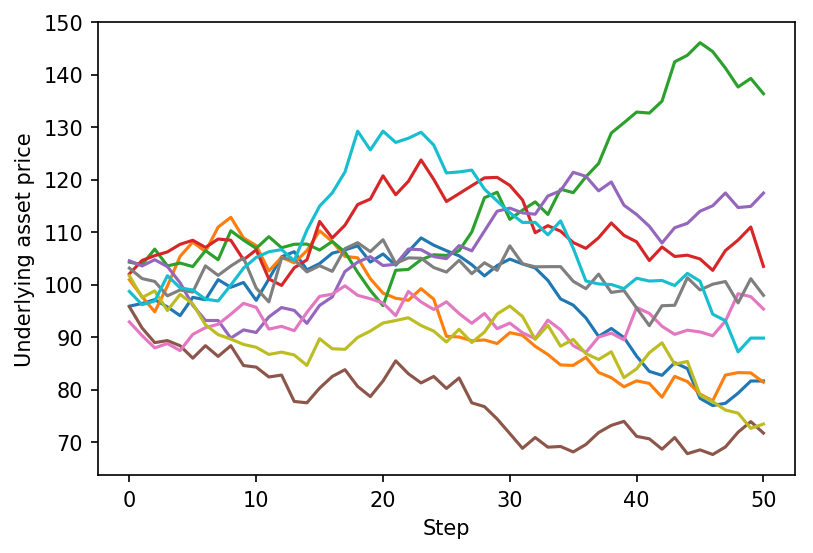

In [87]:
# plot first ten simulated paths
fig, ax = plt.subplots(dpi=150)
ax.plot(S[:, :10])
ax.set_xlabel('Step')
ax.set_ylabel('Underlying asset price')
pass

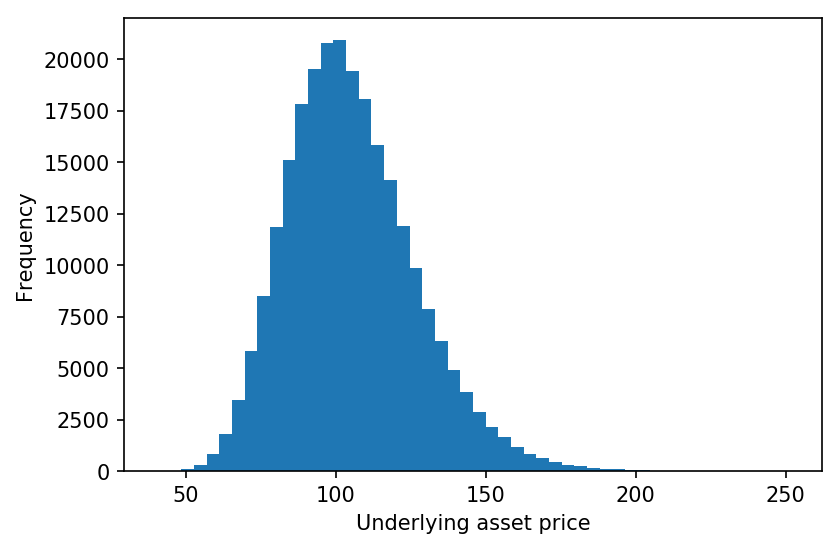

In [69]:
# frequency of simulated prices at the end of simulation
fig, ax = plt.subplots(dpi=150)
ax.hist(S[-1], bins=50)
ax.set_xlabel('Underlying asset price')
ax.set_ylabel('Frequency')
pass

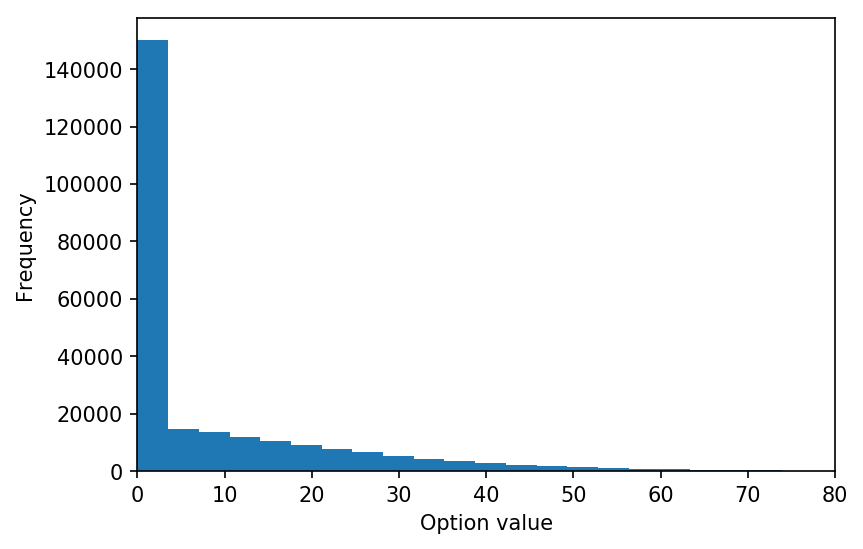

In [88]:
# Simulated option values
fig, ax = plt.subplots(dpi=150)
ax.hist(np.maximum(0, S[-1] - K), bins=50)
ax.set_xlabel('Option value')
ax.set_ylabel('Frequency')
ax.set_xlim(0, 80)
pass

This Figure shows that the option expires worthless most of the time.

## Options pricing using finite difference method 

### The Black-Scholes PDE as a diffusion equation

In order to use the finite difference method for options pricing, the Black-Scholes PDE, a second-order non-linear PDE, is to be transformed to a heat/diffusion equation. The Black-Scholes PDE is written as 

$$ \frac{\partial V}{\partial t} + rS \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} - rV = 0\ ,$$
where $V=V(S,t)$ is the option value.

The trick is to let $y=log S$, such that the geometric Brownian motion becomes an arithmetic Brownian motion, and $\tilde\tau = T-t$ to convert the backward equation (in terms of time) to a forward equation with boundary condition $t=T$ at $\tau=0$. Following these transformations the equation becomes 

$$ -\frac{\partial V}{\partial\tilde\tau} + \big(r-\frac{1}{2}\sigma^2 \big)\frac{\partial V}{\partial y} + \frac{1}{2}\sigma^2 \frac{\partial^2 V}{\partial y^2} - rV = 0 \ .$$

Letting $u = e^{r\tilde\tau} V$, $x = y + (r-\frac{1}{2} \sigma^2) \tilde\tau$, and $\tau=\tilde\tau$, the PDE becomes the diffusion equation with $u = u(x,\tau)$:

$$ \frac{\partial u}{\partial \tau} = \frac{1}{2} \sigma^2 \frac{\partial^2 u}{\partial x^2} \ .$$

### The finite difference method

The central idea is to approximate all derivatives in the PDE by finite differences. The domain in space and time can be (uniformly) partitioned into a mesh grid of $N \times J$ discrete space-time intervals, with increments $\Delta \tau = \frac{T}{N}$ and $\Delta x = \frac{x_J - x_0}{J}$. 

The __explicit difference method__ uses the forward difference at time $t_n$ and second-order central difference for the space derivative at $x_j$ to define the recurrence relation:

$$\frac{\partial u}{\partial \tau} \approx \frac{u_j^{n+1} - u_j^n}{\Delta\tau} = \frac{u_{j+1}^n - 2u_j^n + u_{j-1}^n}{(\Delta x)^2} \approx \frac{\partial^2 u }{\partial x^2} \ .$$ 

The terms can be rearranged to provide a more useful recurrence relation for $u_j^{n+1}$:

$$ u_j^{n+1} = \alpha u_{j-1}^n + (1 - 2\alpha) u_j^n + \alpha u_{j+1}^n \ ,$$

where $\alpha = \frac{\Delta t}{(\Delta x)^2}$. Combining this with the boundary conditions, all $u_j^n$ can be estimated uisng this method. 

N.B.: this finite difference method is stable when $\frac{\Delta t}{(\Delta x)^2} < \frac{1}{2}$, such that $1-2\alpha > 0$. This implies that a small $\Delta t$ and many, small time steps is desirable, whilst a small $\Delta x$ may make the results instable. Therefore, it is less optimal to have too many steps in the space dimension. The __implicit difference method__, which uses the backward difference at time $t_{n+1}$ and second-order central difference at $x_j$, is always convergent. Finally, the __Crank-Nicolson method__ can also be used, which uses the central differences in both space and time dimensions.